## 협업 필터링을 활용한 추천 시스템 구현

README 파일에서 간단하게 알아본 내용들 중 Collaborate Filtering 기법을 활용하여 추천 시스템을 구현해보자.

지금부터 구현할 내용은 책을 추천하는 시스템을 구현해 볼 것이다.

### 라이브러리 임포트

In [1]:
import os
import re
import nltk
import random
import warnings
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings("ignore")

### EDA부터

In [2]:
books = pd.read_csv("./data/Books.csv")
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


일단 `Books.csv`의 컬럼을 하나씩 보자면,

<center>

|컬럼명|설명|
|:--:|:--:|
|ISBN|고유 바코드 넘버|
|Book-Title|책 제목|
|Book-Author|글쓴이|
|Year-Of-Publication|출판일|
|Publisher|출판사|
|Image-URL-S, M, L|크기순 책 이미지|

</center>

다음으로는 Ratings를 간략하게 보자면,

In [3]:
ratings = pd.read_csv("./data/Ratings.csv")
ratings.head()  # 유저의 고유 아이디, 평점 점수, 바코드 넘버

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


마지막으로 user정보를 살펴보자면,

In [4]:
users = pd.read_csv("./data/Users.csv")
users.head()  # 마찬가지로 user 고유 id, 사는 위치, 나이가 간단하게 구성되어 있다.

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [5]:
print(f"Books shape : {books.shape}")
print(f"Ratings shape : {ratings.shape}")
print(f"Users shape : {users.shape}")

Books shape : (271360, 8)
Ratings shape : (1149780, 3)
Users shape : (278858, 3)


### 결측치 확인

In [6]:
print(f"Any null values in Books: \n {books.isnull().sum()}")
print(f"Any null values in Ratings: \n {ratings.isnull().sum()}")
print(f"Any null values in Users: \n {books.isnull().sum()}")

Any null values in Books: 
 ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64
Any null values in Ratings: 
 User-ID        0
ISBN           0
Book-Rating    0
dtype: int64
Any null values in Users: 
 ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64


결측치가 조금씩 보이지만, 이따가 한꺼번에 처리하기 위해서 병합부터 실시한다.

### Preprocessing 시작

In [7]:
books_data = books.merge(ratings, on="ISBN")
books_data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385,0


In [8]:
df = books_data.copy()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.drop(columns=['ISBN', 'Year-Of-Publication', "Image-URL-S", "Image-URL-M"], axis=1, inplace=True)
df.drop(index=df[df['Book-Rating']==0].index, inplace=True)
df['Book-Title'] = df['Book-Title']
df.head()


,Book-Title,Book-Author,Publisher,Image-URL-L,User-ID,Book-Rating
1,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,8,5
3,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,11676,8
5,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,67544,8
8,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,116866,9
9,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,123629,9


### Popularity-Based Recommendation System
유저들의 사랑을 많이 받는, 인기를 기반으로 하는 추천 시스템을 구현해보자.

In [9]:
def popular_books(df, n=100):
    rating_count = df.groupby("Book-Title").count()['Book-Rating'].reset_index()
    rating_count.rename(columns={"Book-Rating":"NumberOfVotes"}, inplace=True)

    rating_average = df.groupby("Book-Title")['Book-Rating'].mean().reset_index()
    rating_average.rename(columns={"Book-Rating":"AverageRatings"}, inplace=True)

    popular_book_table = rating_count.merge(rating_average, on="Book-Title")

    def weighted_rate(x):
        v = x["NumberOfVotes"]
        R = x["AverageRatings"]

        return ((v*R) + (m*C)) / (v+m)
    
    C = popular_book_table['AverageRatings'].mean()
    m = popular_book_table['NumberOfVotes'].quantile(0.90)

    popular_book_table = popular_book_table[popular_book_table["NumberOfVotes"] >= 250]
    popular_book_table["Popularity"] = popular_book_table.apply(weighted_rate, axis=1)
    popular_book_table = popular_book_table.sort_values(by="Popularity", ascending=False)

    return popular_book_table[["Book-Title", "NumberOfVotes", "AverageRatings", "Popularity"]].reset_index(drop=True).head(n)

http://images.amazon.com/images/P/0439136350.01.LZZZZZZZ.jpg


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x00000233E8625400>

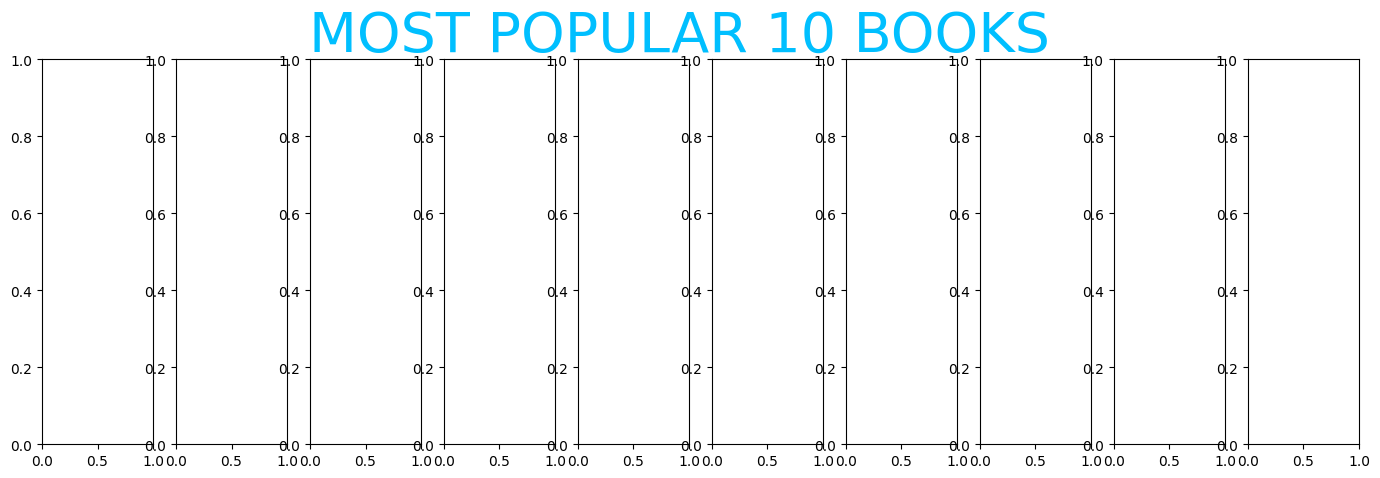

In [13]:
n = 10
top_ten = pd.DataFrame(popular_books(df, 10))
fig, ax = plt.subplots(1, 10, figsize=(17, 5))
fig.suptitle("MOST POPULAR 10 BOOKS", fontsize=40, color="deepskyblue")

for i in range(len(top_ten['Book-Title'].tolist())):
    url = df.loc[df['Book-Title'] == top_ten['Book-Title'].tolist()[i], "Image-URL-L"][:1].values[0]
    img = Image.open(requests.get(url, stream=True).raw)
    ax[i].imshow(img)
    ax[i].axis("off")
    ax[i].set_title("RATING: {} ".format(round(df[df["Book-Title"]==top_ten["Book-Title"].tolist()[i]]["Book-Rating"].mean(),1)),y=-0.20,color="mediumorchid",fontsize=10)
    fig.show()